# Covid-19 
1. Evolução Itália, Espanha e Portugal
2. Comparação entre China e Itália 
3. Número casos, Mortos e Recuperados Portugal e alguns países europeus 

As análises são atualizadas diariamente utilizando dados tratados pelo __Center for Systems Science and Engineering (CSSE) at Johns Hopkins University__ disponiveis em https://github.com/CSSEGISandData/COVID-19

Análise desenvolvida por __Pedro Sobreiro__ e __António Moreira__ professores na Escola Superior de Desporto de Rio Maior e pode ser consultada em https://sobreiro.herokuapp.com/voila/render/analysis/Covid-19.ipynb

In [155]:
# storing and anaysis
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns 
import plotly.express as px

import warnings; 
warnings.simplefilter('ignore')

In [156]:
# importing datasets
full_table = pd.read_csv('https://raw.githubusercontent.com/pesobreiro/jupyternotebooks/master/dados/covid.csv',parse_dates=['Last Update'])


In [157]:
full_table.head(20)

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Anhui,Mainland China,2020-01-22 17:00:00,1.0,NaN,NaN,NaN,NaN
1,Beijing,Mainland China,2020-01-22 17:00:00,14.0,NaN,NaN,NaN,NaN
2,Chongqing,Mainland China,2020-01-22 17:00:00,6.0,NaN,NaN,NaN,NaN
3,Fujian,Mainland China,2020-01-22 17:00:00,1.0,NaN,NaN,NaN,NaN
4,Gansu,Mainland China,2020-01-22 17:00:00,NaN,NaN,NaN,NaN,NaN
5,Guangdong,Mainland China,2020-01-22 17:00:00,26.0,NaN,NaN,NaN,NaN
6,Guangxi,Mainland China,2020-01-22 17:00:00,2.0,NaN,NaN,NaN,NaN
7,Guizhou,Mainland China,2020-01-22 17:00:00,1.0,NaN,NaN,NaN,NaN
8,Hainan,Mainland China,2020-01-22 17:00:00,4.0,NaN,NaN,NaN,NaN
9,Hebei,Mainland China,2020-01-22 17:00:00,1.0,NaN,NaN,NaN,NaN


In [158]:
full_table.columns = ['Province/State', 'Country/Region', 'Date', 'Confirmed',
       'Deaths', 'Recovered', 'Latitude', 'Longitude']

In [159]:
full_table.tail()

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered,Latitude,Longitude
5627,"Virgin Islands, U.S.",US,2020-03-14 16:15:18,1.0,0.0,0.0,18.3358,-64.8963
5628,Gibraltar,United Kingdom,2020-03-14 16:33:03,1.0,0.0,1.0,36.1408,-5.3536
5629,From Diamond Princess,Australia,2020-03-14 02:33:04,0.0,0.0,0.0,35.4437,139.6380
5630,West Virginia,US,2020-03-10 02:33:04,0.0,0.0,0.0,38.4912,-80.9545
5631,NaN,occupied Palestinian territory,2020-03-11 20:53:02,0.0,0.0,0.0,31.9522,35.2332


In [160]:
full_table.Date=full_table['Date'].dt.date

In [161]:
full_table.Date

0       2020-01-22
1       2020-01-22
2       2020-01-22
3       2020-01-22
4       2020-01-22
           ...    
5627    2020-03-14
5628    2020-03-14
5629    2020-03-14
5630    2020-03-10
5631    2020-03-11
Name: Date, Length: 5632, dtype: object

In [162]:
# replacing Mainland china with just China
full_table['Country/Region'] = full_table['Country/Region'].replace('Mainland China', 'China')

# filling missing values with NA
full_table[['Province/State']] = full_table[['Province/State']].fillna('NA')

In [163]:
#full_table.drop_duplicates(subset=['Province/State','Country/Region', 'Date'], keep=False, inplace=True)

In [164]:
full_table.loc[(full_table['Country/Region']=='US')].tail(10)

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered,Latitude,Longitude
5568,Hawaii,US,2020-03-14,4.0,0.0,0.0,21.0943,-157.4983
5569,Missouri,US,2020-03-14,4.0,0.0,0.0,38.4561,-92.2884
5570,Oklahoma,US,2020-03-14,4.0,0.0,0.0,35.5653,-96.9289
5575,Maine,US,2020-03-14,3.0,0.0,0.0,44.6939,-69.3819
5576,Puerto Rico,US,2020-03-14,3.0,0.0,0.0,18.2208,-66.5901
5591,Idaho,US,2020-03-14,2.0,0.0,0.0,44.2405,-114.4788
5592,Wyoming,US,2020-03-14,2.0,0.0,0.0,42.7560,-107.3025
5626,North Dakota,US,2020-03-12,1.0,0.0,0.0,47.5289,-99.7840
5627,"Virgin Islands, U.S.",US,2020-03-14,1.0,0.0,0.0,18.3358,-64.8963
5630,West Virginia,US,2020-03-10,0.0,0.0,0.0,38.4912,-80.9545


In [184]:
full_table.loc[full_table['Country/Region']=='US'].groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].sum().tail(50)

,,Confirmed,Deaths,Recovered
Date,Country/Region,,,
2020-01-22,US,1.0,0.0,0.0
2020-01-23,US,1.0,0.0,0.0
2020-01-24,US,2.0,0.0,0.0
2020-01-25,US,2.0,0.0,0.0
2020-01-26,US,5.0,0.0,0.0
2020-01-27,US,5.0,0.0,0.0
2020-01-28,US,5.0,0.0,0.0
2020-01-29,US,5.0,0.0,0.0
2020-01-30,US,5.0,0.0,0.0


In [167]:
full_table.sort_values(by=['Country/Region','Date'],inplace=True)

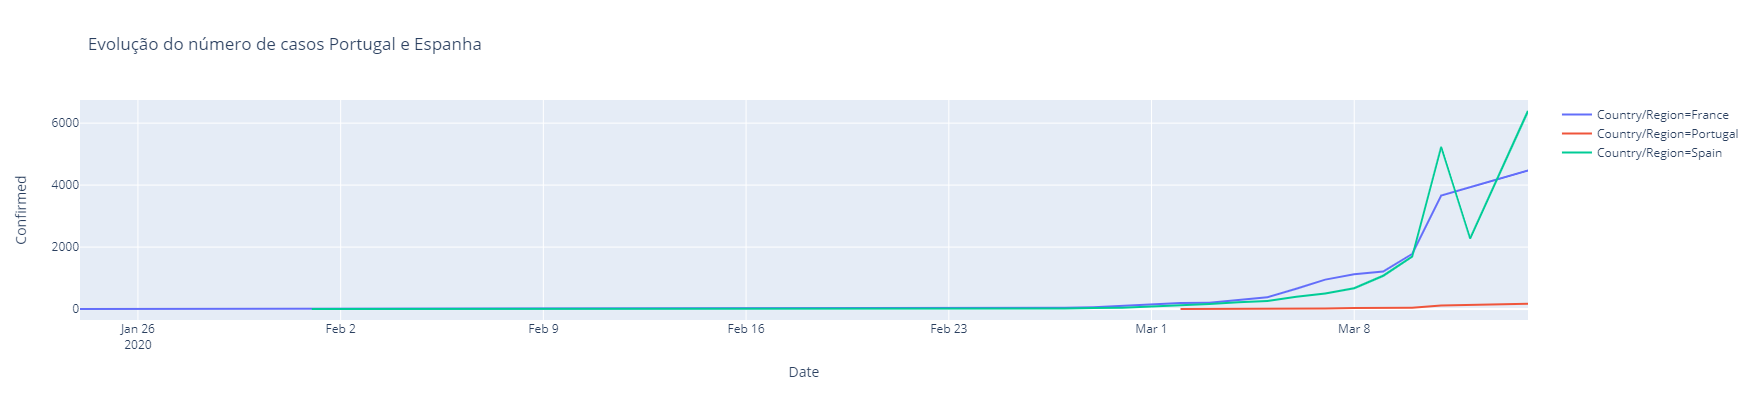

In [181]:
temp = full_table.loc[((full_table['Country/Region']=='Spain')| (full_table['Country/Region']=='Portugal')
                       |(full_table['Country/Region']=='France'))]
#temp = temp.groupby(['Date', 'Country/Region'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)
temp = temp.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered'].max().reset_index()
#temp = full_table.groupby(['Date', 'Country/Region'])['Confirmed'].sum().reset_index().sort_values('Confirmed', ascending=False)
temp.sort_values(by=['Country/Region','Date'],inplace=True)

temp = temp.reset_index()


fig = px.line(temp, x="Date", y="Confirmed", color='Country/Region',height=400,width=1000,
             title='Evolução do número de casos Portugal e Espanha')
fig.show()

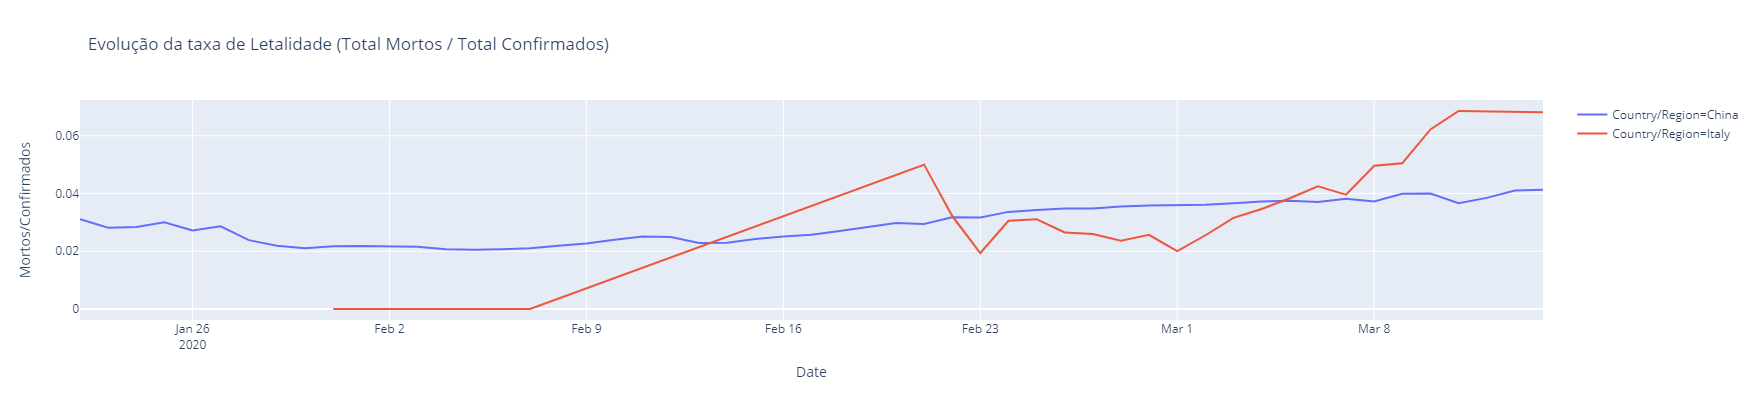

In [169]:
temp = full_table.loc[(full_table['Country/Region']=='Italy') | (full_table['Country/Region']=='China')]
temp = temp.groupby(['Country/Region', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum()

temp = temp.reset_index()
temp['Mortos/Confirmados'] = temp['Deaths']/temp['Confirmed']


fig = px.line(temp, x="Date", y="Mortos/Confirmados", color='Country/Region',height=400,width=1000,
             title='Evolução da taxa de Letalidade (Total Mortos / Total Confirmados)')
fig.show()

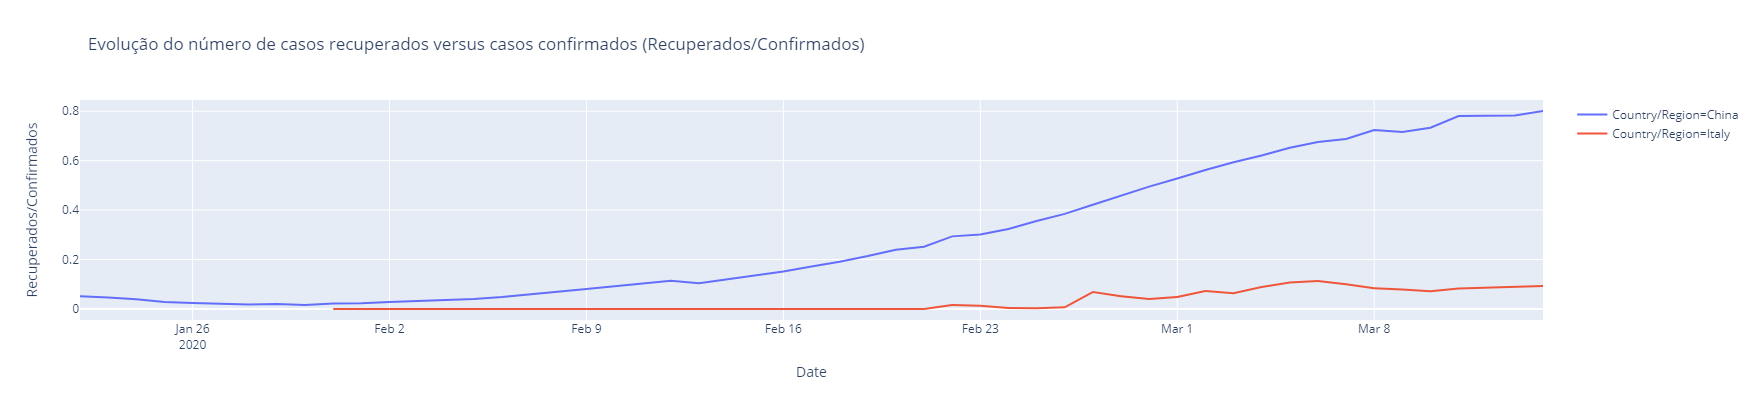

In [170]:
temp['Recuperados/Confirmados'] = temp['Recovered']/temp['Confirmed']

fig = px.line(temp, x="Date", y="Recuperados/Confirmados", color='Country/Region',  height=400,width=1000,
             title='Evolução do número de casos recuperados versus casos confirmados (Recuperados/Confirmados)')
fig.show()

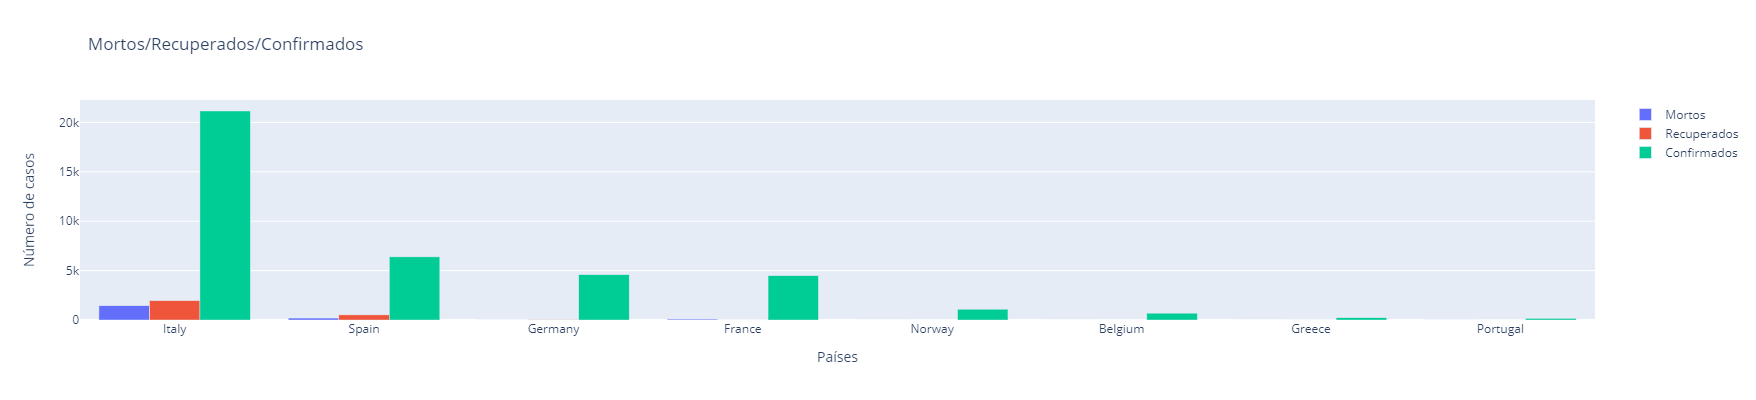

In [171]:
temp = full_table.loc[full_table.Date == full_table.Date.max()]
temp = temp.groupby(['Country/Region'])['Confirmed', 'Deaths', 'Recovered'].sum().sort_values('Confirmed',ascending=False)


europa = ['Italy', 'France', 'Germany', 'Spain', 'Belgium', 'Norway','Greece',  'Portugal']

temp=temp.reset_index()
temp=temp.loc[temp['Country/Region'].isin(europa)]


import plotly.graph_objects as go

layout = go.Layout(height=400,width=1000)

fig = go.Figure(data=[
    go.Bar(name='Mortos', x=temp['Country/Region'], y=temp['Deaths']),
    go.Bar(name='Recuperados', x=temp['Country/Region'], y=temp['Recovered']),
    go.Bar(name='Confirmados', x=temp['Country/Region'], y=temp['Confirmed']),
],layout=layout)

fig.update_layout(
    title="Mortos/Recuperados/Confirmados",
    xaxis_title="Países",
    yaxis_title="Número de casos",
)
fig.show()

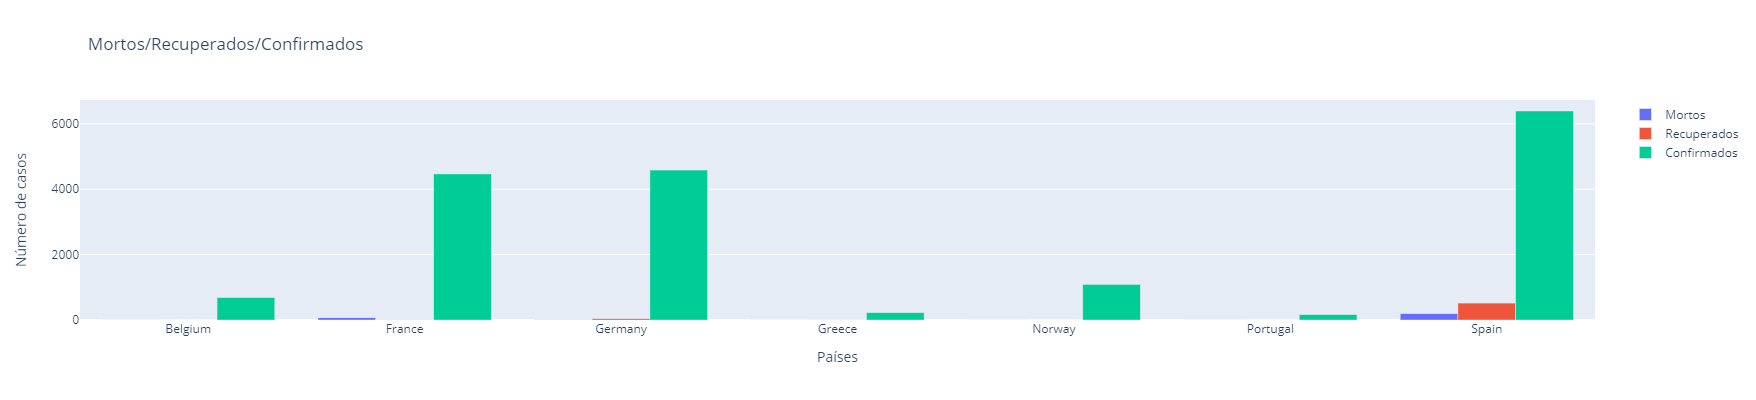

In [172]:
europa = [ 'France', 'Germany', 'Spain', 'Belgium', 'Norway','Greece',  'Portugal']
temp=full_table.loc[full_table.Date == full_table.Date.max()]
temp=temp.reset_index()
temp=temp.loc[temp['Country/Region'].isin(europa)]

layout = go.Layout(height=400,width=1000)

fig = go.Figure(data=[
    go.Bar(name='Mortos', x=temp['Country/Region'], y=temp['Deaths']),
    go.Bar(name='Recuperados', x=temp['Country/Region'], y=temp['Recovered']),
    go.Bar(name='Confirmados', x=temp['Country/Region'], y=temp['Confirmed']),
],layout=layout)

fig.update_layout(
    title="Mortos/Recuperados/Confirmados",
    xaxis_title="Países",
    yaxis_title="Número de casos",
)

fig.show()

## Casos portugal
Dados obtidos em https://github.com/aperaltasantos/covid_pt

In [173]:
# importing datasets
dfPortugal = pd.read_csv('https://raw.githubusercontent.com/pesobreiro/jupyternotebooks/master/dados/covid_pt.csv',parse_dates=['date'])

In [174]:
dfPortugal=dfPortugal.fillna(0)

In [175]:
# dfPortugal.columns

In [176]:
dfPortugal.columns = ['data', 'casos_suspeitos', 'casos_suspeitos_novos', 'confirmados', 'confirmados_novos',
       'internados', 'internados_novos', 'cuidadosIntensivos', 'cuidadosIntensivos_novos', 'recuperados','recuperados_novos', 'mortos', 'mortos_novos']

In [177]:
temp = pd.melt(dfPortugal,id_vars='data',
               value_vars=['casos_suspeitos', 'confirmados', 'internados', 'cuidadosIntensivos', 'mortos'])

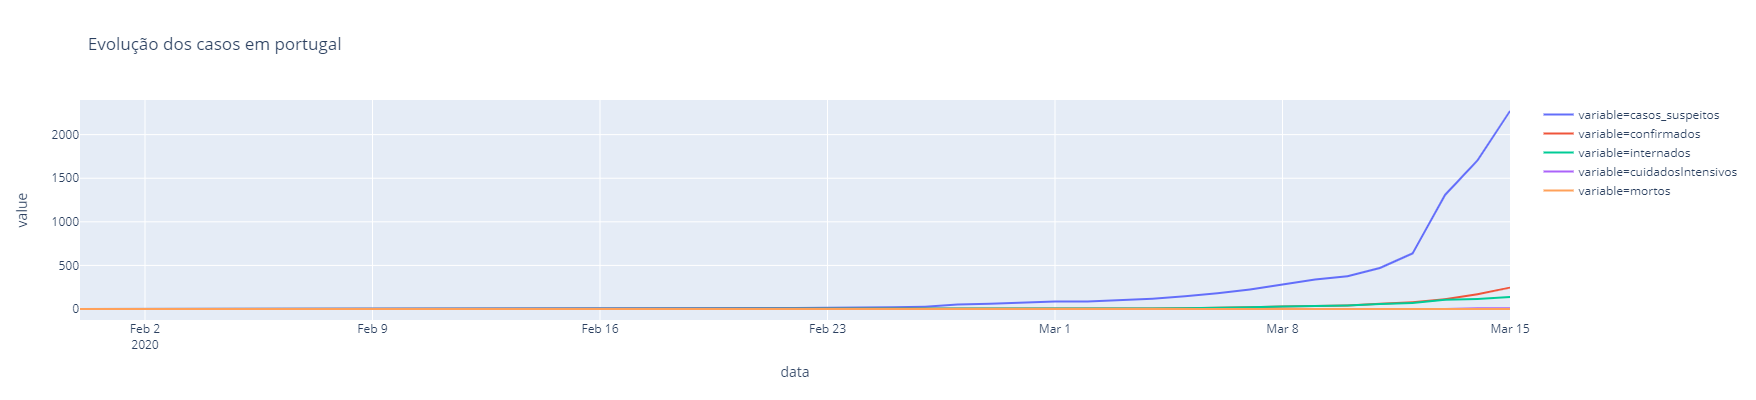

In [178]:
#temp['confirmed'] = temp['Recovered']/temp['Confirmed']

fig = px.line(temp, x="data", y="value", color = 'variable',height=400,width=1000,
             title='Evolução dos casos em portugal')
fig.show()